<a href="https://colab.research.google.com/github/tngjody/bt4221-airfare-booking/blob/main/BT4221_Group_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BT4221 Group 20: Optimising Airfare Booking with Predictive Analytics

Group Members:

Gong Yongjia A0286144X

Jody Tng Jin Zi A0238195W

Wu Shuhan A0266501L

Zhou Jingchu Jeslyn A0275993H

### Importing Libraries

In [4]:
# PySpark Imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, isnan, datediff, lit, sum, percentile_approx, mean, stddev, count
from pyspark.sql.types import NumericType, DoubleType, IntegerType, FloatType, DateType, StringType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
import math


# Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Other Imports
from datetime import datetime
from datetime import timedelta

# 1.1 Data Loading

#### **1.1. Initialize Spark Session & Load Dataset**

In [2]:
# Initialize Spark Sesison
spark = SparkSession.builder.appName("FlightPrices").getOrCreate()

# Load Dataset
flight_df = spark.read.csv("flight.csv", header=True, inferSchema=True)

# Show a sample (5 rows) of the data
flight_df.show(5, truncate=False)

# Display schema
flight_df.printSchema()
flight_df.filter(F.col("totalTravelDistance").isNull()) \
    .select("legid", "totalTravelDistance", "segmentsDistance") \
    .show(1, truncate=False)



25/03/27 21:30:26 WARN Utils: Your hostname, Jeslyns-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.3 instead (on interface en0)
25/03/27 21:30:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/27 21:30:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/27 21:30:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------------------------------------------+-------------------------------+------------------------------------------------------------+--------------------------+----------------------------+-------------------+-------------------+------------------------------+-------------------------+----------------+-----------------+
|legId                           |searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw                                    |segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw                          

# 1.2 EDA on Raw Data

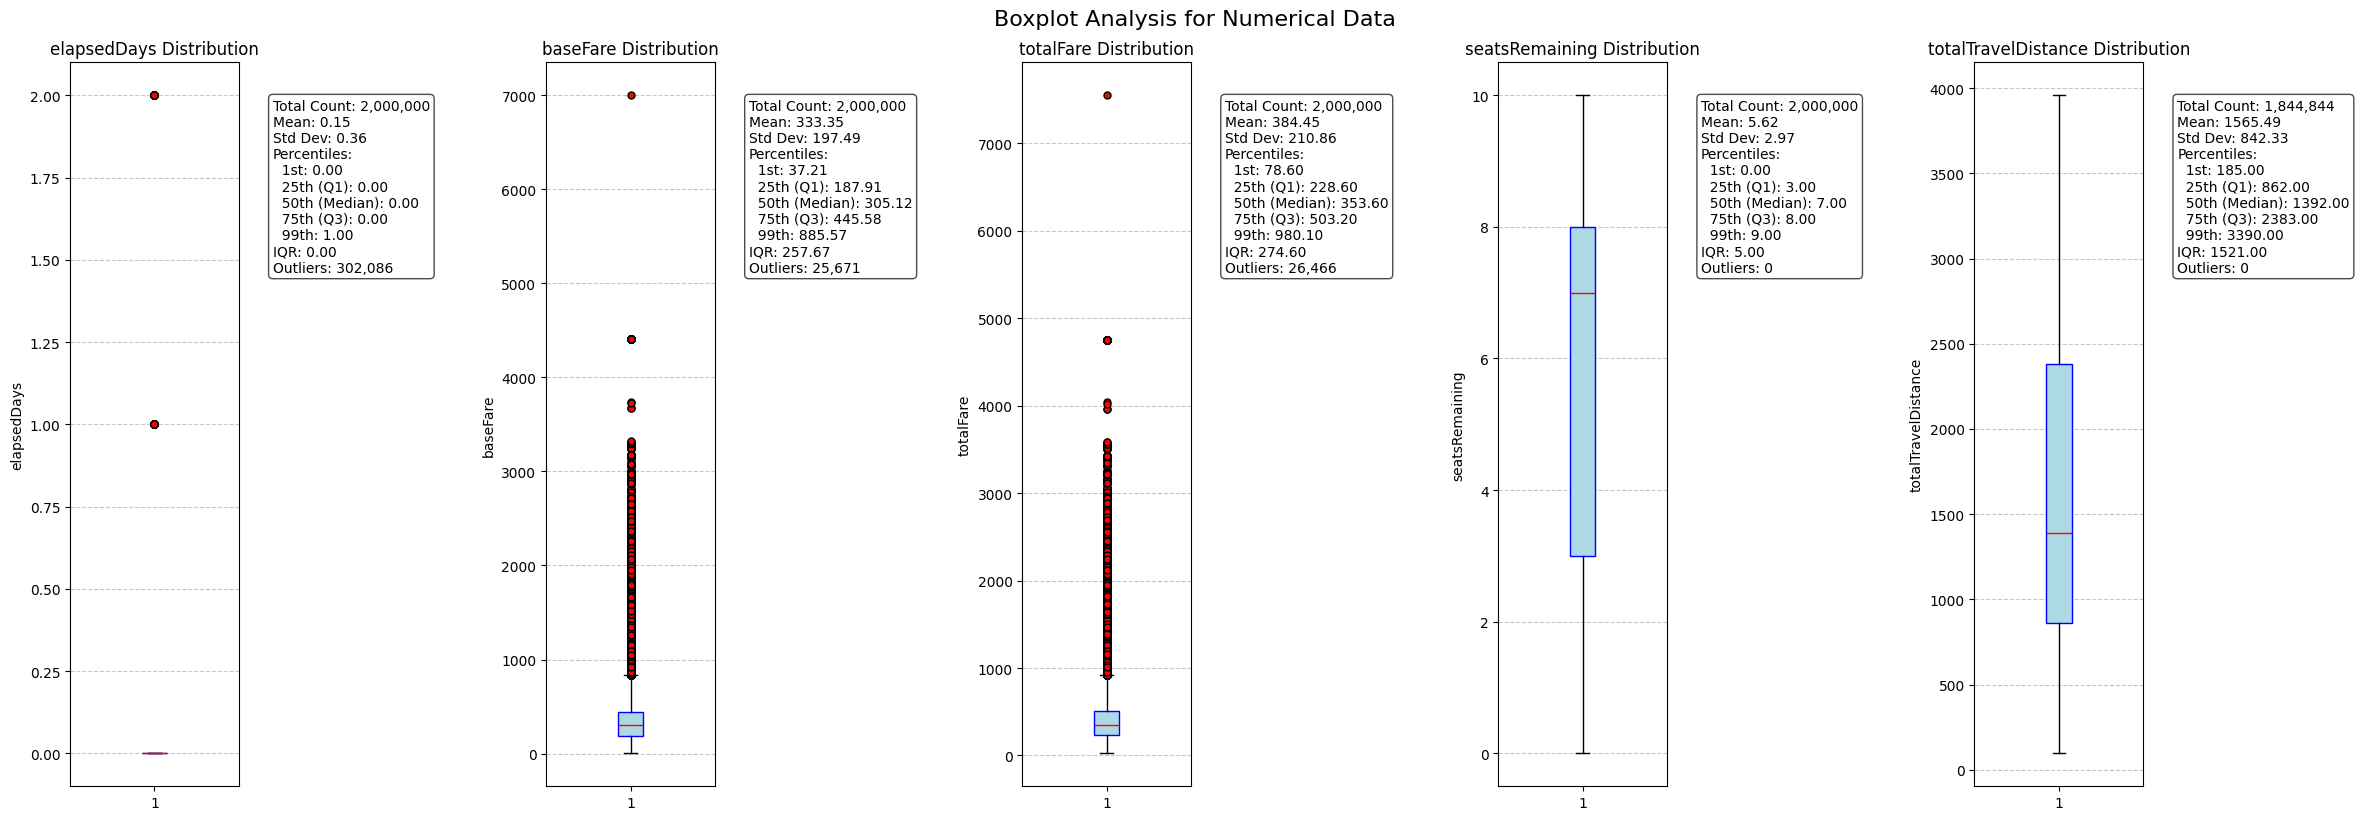

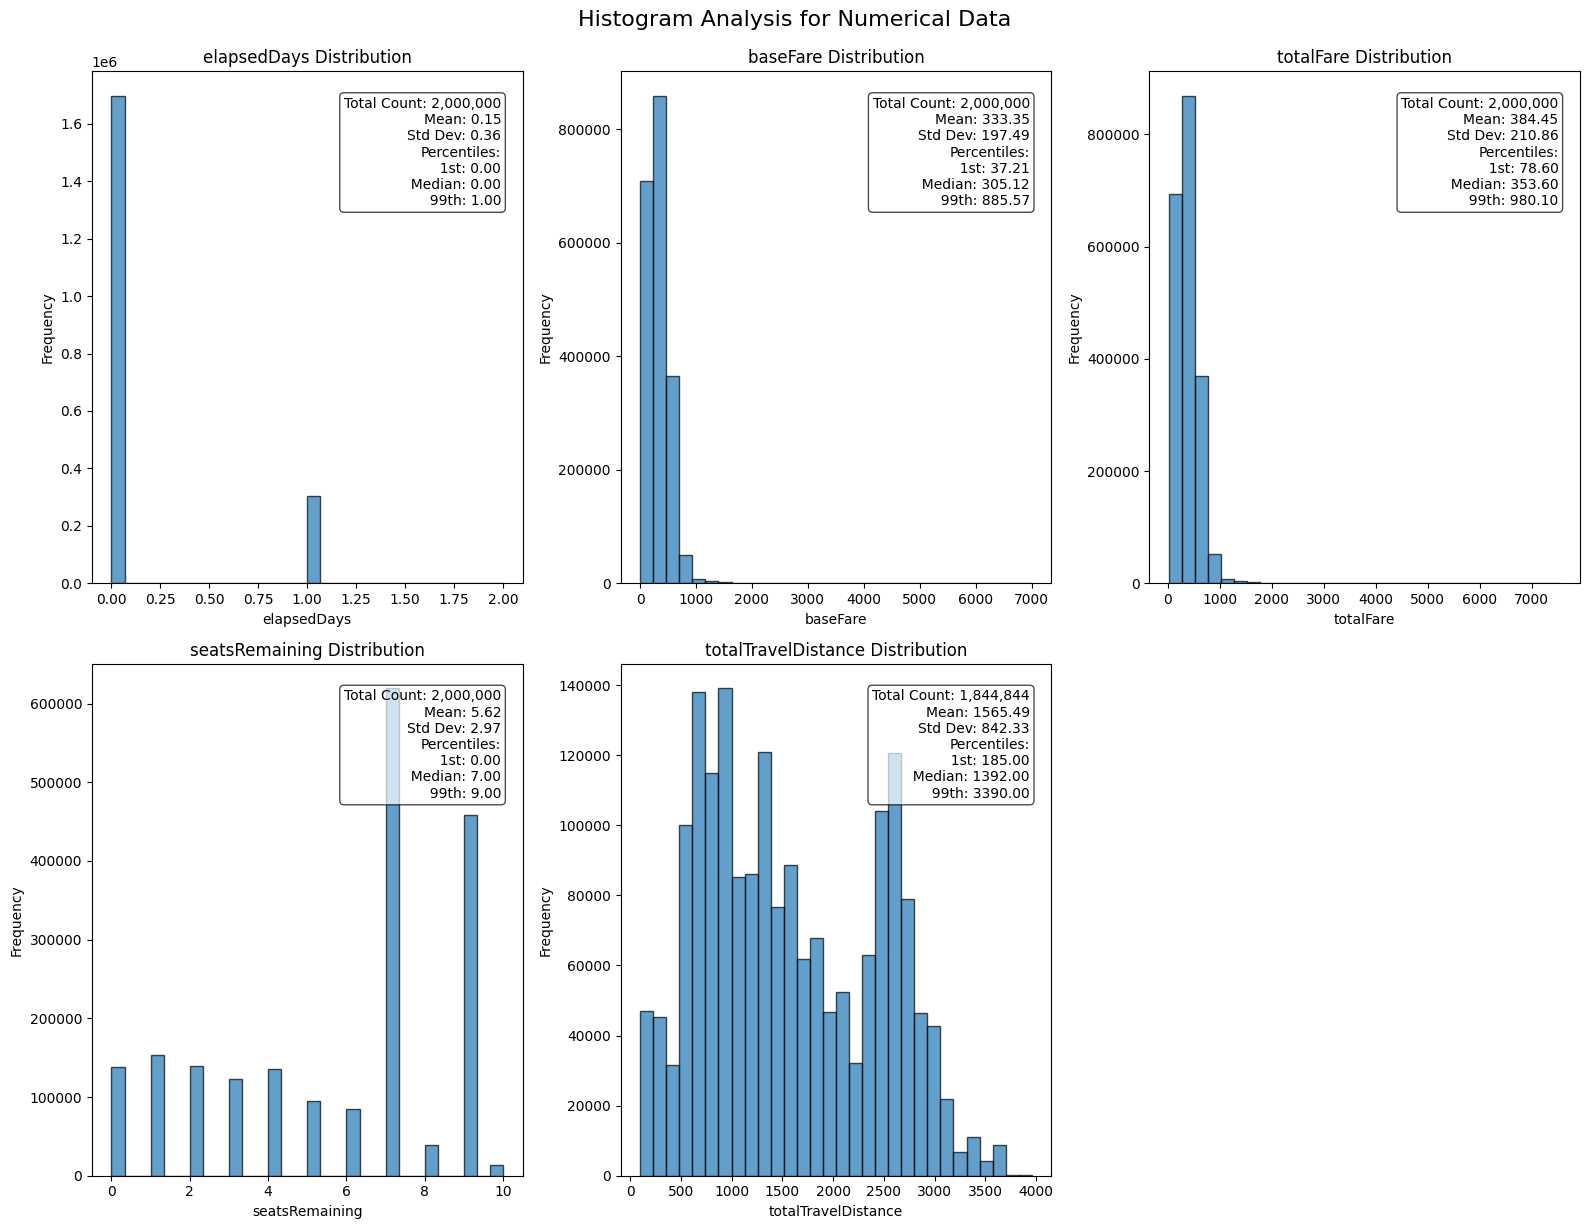

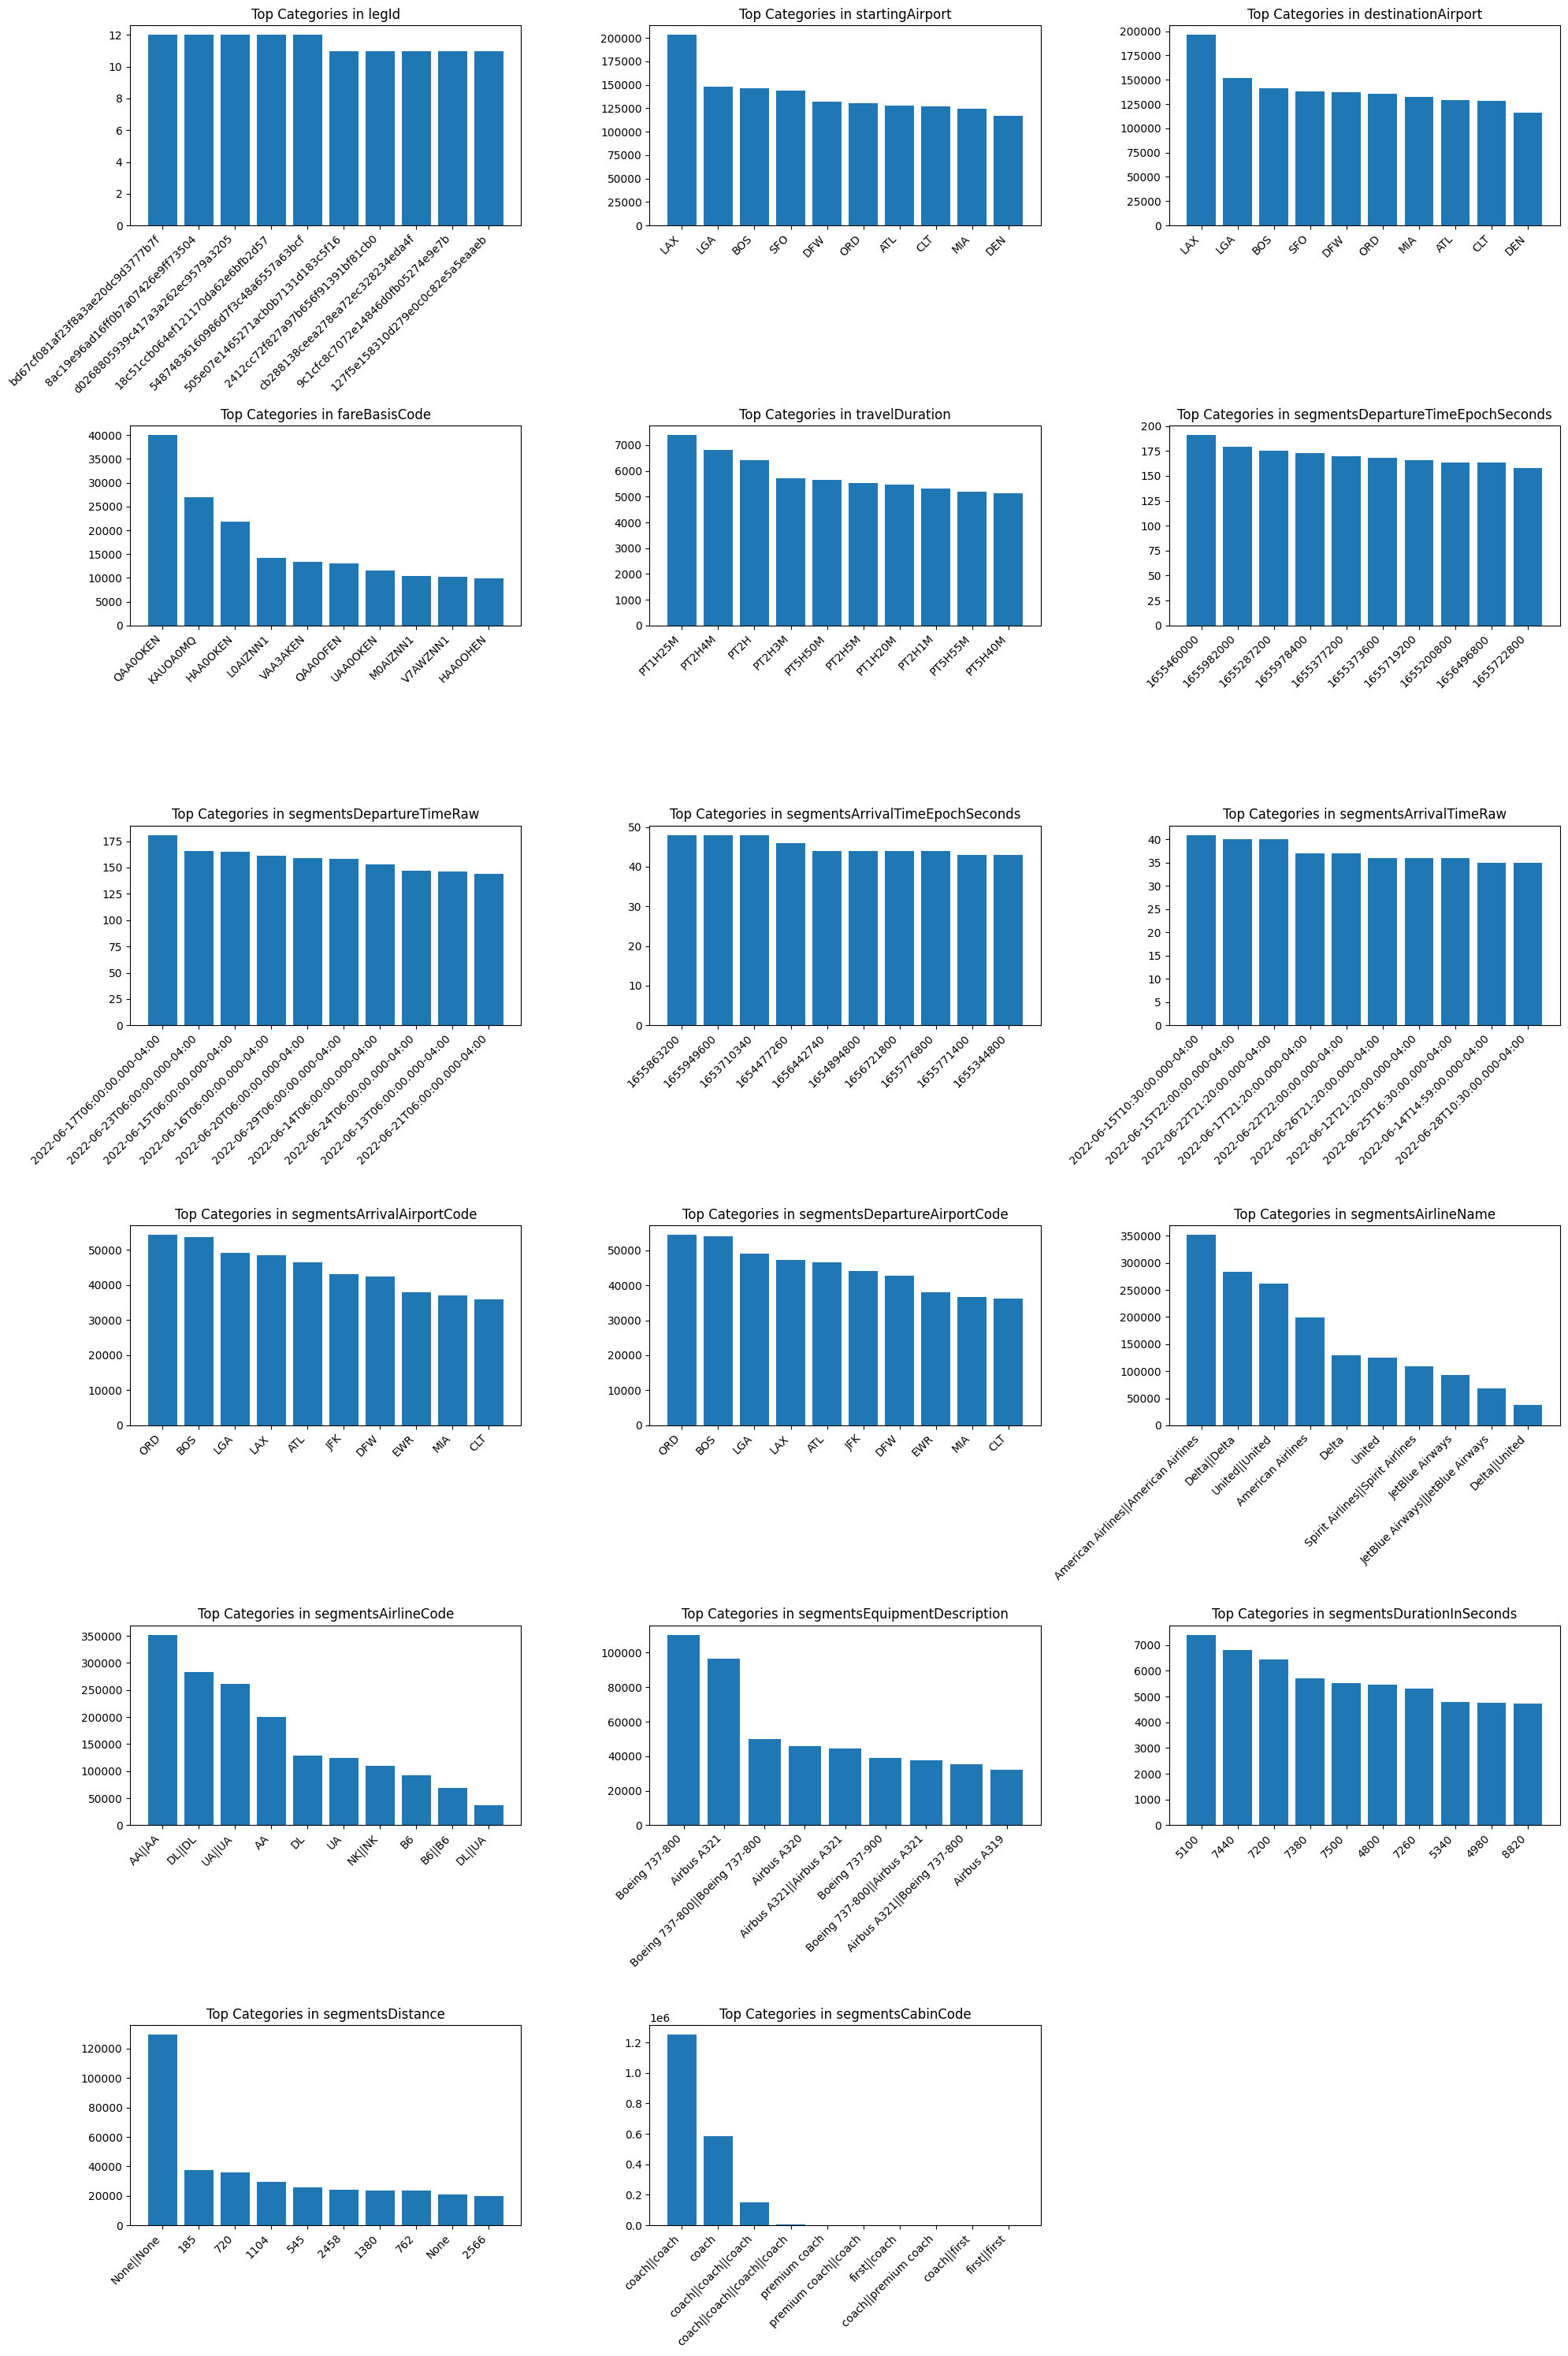

In [5]:
# Box plot for numeric data
def create_pyspark_boxplots(df, columns):
    plt.figure(figsize=(24, 8))
    
    for i, column in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        
        # Collect numeric data
        data = df.select(column).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
        
        # Create boxplot
        plt.boxplot(data, 
                    patch_artist=True,  
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    flierprops=dict(marker='o', 
                                    markerfacecolor='red', 
                                    markersize=5, 
                                    linestyle='none'))
        
        # Compute comprehensive statistics
        stats = df.agg(
            count(column).alias('total_count'),
            mean(column).alias('mean'),
            stddev(column).alias('std'),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias('percentiles')
        ).collect()[0]
        
        # Extract statistics
        total_count = stats['total_count']
        mean_val = stats['mean']
        std_val = stats['std']
        percentiles = stats['percentiles']
        q1, median, q3 = percentiles[1], percentiles[2], percentiles[3]
        iqr = q3 - q1
        
        # Identify outliers
        outliers = df.filter(
            (col(column) < percentiles[1] - 1.5 * (percentiles[3] - percentiles[1])) | 
            (col(column) > percentiles[3] + 1.5 * (percentiles[3] - percentiles[1]))
        )
        outliers_count = outliers.count()
        
        # Annotate plot
        plt.title(f'{column} Distribution', fontsize=12)
        plt.ylabel(column, fontsize=10)
        
        # Add text annotations with comprehensive analysis
        plt.text(1.2, 0.95, 
                 f'Total Count: {total_count:,}\n'
                 f'Mean: {mean_val:.2f}\n'
                 f'Std Dev: {std_val:.2f}\n'
                 f'Percentiles:\n'
                 f'  1st: {percentiles[0]:.2f}\n'
                 f'  25th (Q1): {q1:.2f}\n'
                 f'  50th (Median): {median:.2f}\n'
                 f'  75th (Q3): {q3:.2f}\n'
                 f'  99th: {percentiles[4]:.2f}\n'
                 f'IQR: {iqr:.2f}\n'
                 f'Outliers: {outliers_count:,}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top', 
                 horizontalalignment='left',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.suptitle('Boxplot Analysis for Numerical Data', fontsize=16, y=1.02)
    plt.show()

# Histograms for numeric data
def create_pyspark_histograms(df, columns):
    plt.figure(figsize=(16, 12))
    
    for i, column in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        
        # Collect numeric data
        data = df.select(column).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
        
        # Create histogram
        plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
        
        # Compute comprehensive statistics
        stats = df.agg(
            count(column).alias('total_count'),
            mean(column).alias('mean'),
            stddev(column).alias('std'),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias('percentiles')
        ).collect()[0]
        
        # Add statistical annotations
        plt.title(f'{column} Distribution', fontsize=12)
        plt.xlabel(column, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
        
        # Annotate with statistics
        plt.text(0.95, 0.95, 
                 f'Total Count: {stats["total_count"]:,}\n'
                 f'Mean: {stats["mean"]:.2f}\n'
                 f'Std Dev: {stats["std"]:.2f}\n'
                 f'Percentiles:\n'
                 f'  1st: {stats["percentiles"][0]:.2f}\n'
                 f'  Median: {stats["percentiles"][2]:.2f}\n'
                 f'  99th: {stats["percentiles"][4]:.2f}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top', 
                 horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.suptitle('Histogram Analysis for Numerical Data', fontsize=16, y=1.02)
    plt.show()
  
def run_pyspark_analysis(df):
    # numeric columns
    numeric_cols = [col for col, dtype in df.dtypes if dtype in ('int', 'double')]
    
    # Create visualizations
    create_pyspark_boxplots(df, numeric_cols)
    create_pyspark_histograms(df, numeric_cols)

run_pyspark_analysis(flight_df)


def explore_categorical_columns(df):
    """
    Analyze all categorical columns in the DataFrame with visualization using bar plots
    """
    # Identify categorical columns by checking for string type columns
    categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
    
    # If no categorical columns are found, return a message
    if not categorical_columns:
        print("No categorical columns found.")
        return
    
    # Determine the number of rows and columns for the subplots
    num_columns = len(categorical_columns)
    num_rows = math.ceil(num_columns / 3)  # For 3 columns per row

    # Plotting setup
    plt.figure(figsize=(20, num_rows * 5))  # Adjust the figure size dynamically

    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, 3, i)  # Dynamic row and column setup
        
        # Handle columns with multiple values separated by '||'
        if '||' in str(df.select(column).first()[column]):
            # Split and explode the column to count individual values
            value_counts = df.select(column) \
                .withColumn("split_values", split(col(column), "\\|\\|")) \
                .withColumn("exploded_values", explode(col("split_values"))) \
                .groupBy("exploded_values") \
                .count() \
                .orderBy("count", ascending=False)
        else:
            # Standard categorical value counts
            value_counts = df.groupBy(column) \
                .count() \
                .orderBy("count", ascending=False)
        
        # Limit to top 10 categories for better visualization
        top_categories = value_counts.limit(10).toPandas()

        # Drop rows with None values in the column or 'count'
        top_categories = top_categories.dropna(subset=[column, 'count'])

        # Plot the bar chart if there are any categories left
        if not top_categories.empty:
            plt.bar(top_categories[column], top_categories['count'])
            plt.title(f'Top Categories in {column}')
            plt.xticks(rotation=45, ha='right')
        else:
            plt.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

        plt.tight_layout()

    # Display the plots
    plt.show()

explore_categorical_columns(flight_df)

# 2.1 Data Cleaning

In [ ]:
def show_missing_values(df):
    missing_exprs = []
    for field in df.schema.fields:
        if isinstance(field.dataType, NumericType):
            # For numeric columns, count both nulls and NaNs
            expr = sum(
                (col(field.name).isNull() | isnan(col(field.name))).cast("int")
            ).alias(field.name)
        elif isinstance(field.dataType, StringType):
            # For string columns, count nulls and empty strings
            expr = sum(
                (col(field.name).isNull() | (col(field.name) == "")).cast("int")
            ).alias(field.name)
        else:
            # For other columns, count only nulls
            expr = sum(col(field.name).isNull().cast("int")).alias(field.name)
        missing_exprs.append(expr)

    # Compute and display missing values count per column
    missing_counts = df.select(*missing_exprs)
    print("\nMissing values count for each column:")
    missing_counts.show()
    
    # Calculate and display percentage of missing values
    total_rows = df.count()
    missing_percentages = missing_counts.toPandas().iloc[0].apply(lambda x: f"{(x/total_rows)*100:.2f}%")
    print("\nPercentage of missing values:")
    print(missing_percentages)

print("Before dropping null rows:")
show_missing_values(flight_df)

Before dropping null rows:

Missing values count for each column:


+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---


Percentage of missing values:
legId                                0.00%
searchDate                           0.00%
flightDate                           0.00%
startingAirport                      0.00%
destinationAirport                   0.00%
fareBasisCode                        0.00%
travelDuration                       0.00%
elapsedDays                          0.00%
isBasicEconomy                       0.00%
isRefundable                         0.00%
isNonStop                            0.00%
baseFare                             0.00%
totalFare                            0.00%
seatsRemaining                       0.00%
totalTravelDistance                  7.76%
segmentsDepartureTimeEpochSeconds    0.00%
segmentsDepartureTimeRaw             0.00%
segmentsArrivalTimeEpochSeconds      0.00%
segmentsArrivalTimeRaw               0.00%
segmentsArrivalAirportCode           0.00%
segmentsDepartureAirportCode         0.00%
segmentsAirlineName                  0.00%
segmentsAirlineCode    

In [ ]:
# drop rows with null values in TravelDistance
flight_df = flight_df.dropna(subset=["totalTravelDistance"])

In [ ]:
print("After dropping null rows:")
show_missing_values(flight_df)

After dropping null rows:

Missing values count for each column:


+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---


Percentage of missing values:
legId                                0.00%
searchDate                           0.00%
flightDate                           0.00%
startingAirport                      0.00%
destinationAirport                   0.00%
fareBasisCode                        0.00%
travelDuration                       0.00%
elapsedDays                          0.00%
isBasicEconomy                       0.00%
isRefundable                         0.00%
isNonStop                            0.00%
baseFare                             0.00%
totalFare                            0.00%
seatsRemaining                       0.00%
totalTravelDistance                  0.00%
segmentsDepartureTimeEpochSeconds    0.00%
segmentsDepartureTimeRaw             0.00%
segmentsArrivalTimeEpochSeconds      0.00%
segmentsArrivalTimeRaw               0.00%
segmentsArrivalAirportCode           0.00%
segmentsDepartureAirportCode         0.00%
segmentsAirlineName                  0.00%
segmentsAirlineCode    

# 2.2 Data Preprocessing

def convert_duration_to_hours(duration_col):
    # Extract hours and minutes using regexp_extract
    hours = F.regexp_extract(duration_col, r"PT(\d+)H", 1).cast("double")
    minutes = F.regexp_extract(duration_col, r"H(\d+)M", 1).cast("double")

    # Calculate total hours and round to nearest 0.25
    total_hours = hours + (minutes / 60)
    rounded_hours = F.round(total_hours * 2) / 2
    
    return rounded_hours

This function calculates total layover time in hours between segments by taking the difference between subsequent segment arrival and departure times.

*Rationale*: Layover duration is a critical feature for understanding the overall travel experience. Long layovers can significantly impact passenger satisfaction and travel time. By calculating the total layover duration, we can better analyze and optimize flight schedules, pricing, and passenger preferences.


In [ ]:
def calculate_layover_duration():
    return F.when(
        F.size(F.split("segmentsDepartureTimeEpochSeconds", "\\|\\|")) <= 1,
        0.0,  # No layover for single segment
    ).otherwise(
        # For multiple segments:
        # 1. Split the arrival and departure times into arrays
        # 2. Calculate differences between next departure and previous arrival
        # 3. Sum up the differences and convert to hours
        # 4. Round to nearest 0.5 hours
        F.round(
            F.expr(
                """
                (
                    aggregate(
                        zip_with(
                            slice(split(segmentsDepartureTimeEpochSeconds, '\\\\|\\\\|'), 2, size(split(segmentsDepartureTimeEpochSeconds, '\\\\|\\\\|'))),
                            slice(split(segmentsArrivalTimeEpochSeconds, '\\\\|\\\\|'), 1, size(split(segmentsArrivalTimeEpochSeconds, '\\\\|\\\\|')) - 1),
                            (x, y) -> cast(x as double) - cast(y as double)
                        ),
                        0D,
                        (acc, x) -> acc + x
                    ) / 3600
                ) * 2
            """
            )
        )
        / 2
    )

#### **2.4. Generate Holiday Dates (±1 day buffer)**

Create a list of holidays and include the day before and after to account for travel surrounding holidays

In [ ]:
holiday_data = [
    ("Good Friday", "2022-04-15"),
    ("Labor Day (International)", "2022-05-01"),
    ("Memorial Day", "2022-05-30"),
    ("Juneteenth (observed)", "2022-06-20"),
    ("Independence Day", "2022-07-04"),
]
holiday_df = spark.createDataFrame(holiday_data, ["holiday_name", "date"])
holiday_df = holiday_df.withColumn("date", F.to_date(F.col("date")))

# Create an array of dates (holiday-1, holiday, holiday+1) for each holiday
holiday_dates = set()
for row in holiday_data:
    holiday_date = F.to_date(F.lit(row[1])).cast(DateType())
    date_val = holiday_df.select(holiday_date).collect()[0][0]
    holiday_dates.add(date_val.strftime("%Y-%m-%d"))
    holiday_dates.add((date_val + timedelta(days=1)).strftime("%Y-%m-%d"))
    holiday_dates.add((date_val - timedelta(days=1)).strftime("%Y-%m-%d"))
holiday_dates_list = list(holiday_dates)

#### **2.5. Select and Engineer Features from Flight Data**


In [ ]:
cleaned_flight_df = flight_df.select(
    'legid', # Keep original flight ID
    'totalFare', # Keep original total fare
    F.col('startingAirport').cast('string'), # ensure the string type
    F.col('destinationAirport').cast('string'), # ensure the string type
    
    # Convert duration format (PT2H30M) to hours (2.5)
    convert_duration_to_hours(F.col('travelDuration')).alias('travelDuration'),
    
    # ensure the integer type
    F.col('elapsedDays').cast('int').alias('elapsedDays'),
    
    # Convert boolean 'true'/'false' strings to 1/0 integers
    F.when(F.col('isBasicEconomy') == 'true', 1).otherwise(0).cast('int').alias('isBasicEconomy'),
    F.when(F.col('isRefundable') == 'true', 1).otherwise(0).cast('int').alias('isRefundable'),
    F.col('seatsRemaining').cast('int').alias('seatsRemaining'),
    
     # Check if flight date is within ±1 day of holidays
    F.when(
        F.date_format('flightDate', 'yyyy-MM-dd').isin(holiday_dates_list),
        1
    ).otherwise(0).cast('int').alias('isFestival'),
    
    # Calculate total distance (use segments if total not available)
    'totalTravelDistance', # Keep original total travel distance
    
    # Calculate days between search and flight date
    F.datediff(F.col('flightDate'), F.col('searchDate')).cast('int').alias('daysUntilDeparture'),
    
    # Extract day of week (Mon, Tue, etc.)
    F.date_format(F.col('flightDate'), 'E').alias('dayOfTheWeek'),
    
    # Count number of flight segments (1 if no '||', else count + 1)
    F.when(F.col('segmentsDistance').contains('||'),
           F.size(F.split('segmentsDistance', '\\|\\|')) + 1
    ).otherwise(1).cast('int').alias('numOfSegments'),
    
     # Calculate total layover time between segments
    calculate_layover_duration().alias('layoverDuration'),
    
    # Create binary indicators (1/0) for each airline's presence in the journey
    *[F.when(F.col('segmentsAirlineCode').contains(code), 1).otherwise(0).cast('int').alias(code)
      for code in ['UA','NK','AA','4B','LF','B6','DL','9K','F9','HA','9X','AS','KG','SY']],
    # F.when(F.col('segmentsAirlineCode').contains('UA'), 1).otherwise(0).cast('int').alias('UA'),
    # F.when(F.col('segmentsAirlineCode').contains('NK'), 1).otherwise(0).cast('int').alias('NK'),
    # F.when(F.col('segmentsAirlineCode').contains('AA'), 1).otherwise(0).cast('int').alias('AA'),
    # F.when(F.col('segmentsAirlineCode').contains('4B'), 1).otherwise(0).cast('int').alias('4B'),
    # F.when(F.col('segmentsAirlineCode').contains('LF'), 1).otherwise(0).cast('int').alias('LF'),
    # F.when(F.col('segmentsAirlineCode').contains('B6'), 1).otherwise(0).cast('int').alias('B6'),
    # F.when(F.col('segmentsAirlineCode').contains('DL'), 1).otherwise(0).cast('int').alias('DL'),
    # F.when(F.col('segmentsAirlineCode').contains('9K'), 1).otherwise(0).cast('int').alias('9K'),
    # F.when(F.col('segmentsAirlineCode').contains('F9'), 1).otherwise(0).cast('int').alias('F9'),
    # F.when(F.col('segmentsAirlineCode').contains('HA'), 1).otherwise(0).cast('int').alias('HA'),
    # F.when(F.col('segmentsAirlineCode').contains('9X'), 1).otherwise(0).cast('int').alias('9X'),
    # F.when(F.col('segmentsAirlineCode').contains('AS'), 1).otherwise(0).cast('int').alias('AS'),
    # F.when(F.col('segmentsAirlineCode').contains('KG'), 1).otherwise(0).cast('int').alias('KG'),
    # F.when(F.col('segmentsAirlineCode').contains('SY'), 1).otherwise(0).cast('int').alias('SY'),
    F.array_contains(F.split(F.col('segmentsCabinCode'), '\\|'), 'business').cast('int').alias('hasBusinessClass'),
    F.array_contains(F.split(F.col('segmentsCabinCode'), '\\|'), 'first').cast('int').alias('hasFirstClass'),
)
cleaned_flight_df.show()

+--------------------+---------+---------------+------------------+--------------+-----------+--------------+------------+--------------+----------+-------------------+------------------+------------+-------------+---------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----------------+-------------+
|               legid|totalFare|startingAirport|destinationAirport|travelDuration|elapsedDays|isBasicEconomy|isRefundable|seatsRemaining|isFestival|totalTravelDistance|daysUntilDeparture|dayOfTheWeek|numOfSegments|layoverDuration| UA| NK| AA| 4B| LF| B6| DL| 9K| F9| HA| 9X| AS| KG| SY|hasBusinessClass|hasFirstClass|
+--------------------+---------+---------------+------------------+--------------+-----------+--------------+------------+--------------+----------+-------------------+------------------+------------+-------------+---------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----------------+-------------+
|620cd51404373b9bd...|  1028.61|            LA

# 3 EDA on Processed Data

### Distribution of Categorical Columns

In [ ]:
categorical_cols = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'isRefundable', 'isNonStop']

def explore_categorical(df, column):
    category_counts = df.groupBy(column).agg(F.count("*").alias("count")).orderBy(F.col("count").desc())
    category_counts.show(5, truncate=False) # Show top 5 categories

# Explore frequency counts for categorical columns
for col_name in categorical_cols:
    explore_categorical(flight_df, col_name) 

# Fare Distribution by Airline
if 'segmentsAirlineCode' in flight_df.columns:
    # Extract the first airline code for each flight
    flight_df = flight_df.withColumn('primaryAirline', F.split(F.col('segmentsAirlineCode'), r'\|\|').getItem(0)) 
    
    # Calculate fare statistics by airline
    airline_stats = flight_df.groupBy("primaryAirline").agg(
        F.count("*").alias("count"),
        F.mean("baseFare").alias("mean_fare"),
        F.stddev("baseFare").alias("stddev_fare"),
        F.min("baseFare").alias("min_fare"),
        F.max("baseFare").alias("max_fare"),
        F.percentile_approx("baseFare", [0.25, 0.5, 0.75], 10000).alias("percentiles")
    ).orderBy(F.col("count").desc())
    

In [ ]:
# Filter out rows with inconsistent 'numSegments' for the same 'airportPair'
numerical_cols = [col for col, dtype in flight_df.dtypes if dtype in ("int", "double")]

for col_name in numerical_cols:
    stats = flight_df.select(
        F.mean(F.col(col_name)).alias("mean"),
        F.stddev(F.col(col_name)).alias("stddev"),
        F.min(F.col(col_name)).alias("min"),
        F.max(F.col(col_name)).alias("max"),
        F.percentile_approx(F.col(col_name), [0.25, 0.5, 0.75], 10000).alias(
            "percentiles"
        ),
    ).collect()[0]

    mean_val = stats["mean"]
    stddev_val = stats["stddev"]
    min_val = stats["min"]
    max_val = stats["max"]
    percentiles = stats["percentiles"]

    bin_width = (max_val - min_val) / 10
    bins = [min_val + i * bin_width for i in range(11)]

    for i in range(10):
        lower = bins[i]
        upper = bins[i + 1]
        count = flight_df.filter(
            (F.col(col_name) >= lower) & (F.col(col_name) < upper)
        ).count()


# Function to collect data for visualization
def collect_data_for_viz(df, columns, limit=10000):
    return df.select(columns).limit(limit).collect()


# Create histogram visualization for totalFare using PySpark
# Get min, max, and use PySpark to count frequencies in bins
min_max = flight_df.select(F.min("totalFare"), F.max("totalFare")).collect()[0]
min_fare, max_fare = min_max[0], min_max[1]
num_bins = 30
bin_width = (max_fare - min_fare) / num_bins

# Create bins and count records in each bin
bins = []
counts = []
for i in range(num_bins):
    lower = min_fare + i * bin_width
    upper = min_fare + (i + 1) * bin_width
    count = flight_df.filter(
        (F.col("totalFare") >= lower) & (F.col("totalFare") < upper)
    ).count()
    bins.append((lower + upper) / 2)  # Use bin center for x-axis
    counts.append(count)

# Create histogram with matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bins, counts, width=bin_width * 0.8)
ax.set_xlabel("Total Fare (USD)")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Total Fare")
ax.grid(alpha=0.3)

# Display histogram
plt.tight_layout()
plt.show()

In [ ]:
# Create fare comparison for direct vs. connecting flights
if 'isNonStop' in flight_df.columns and 'baseFare' in flight_df.columns: 
    
    # Group data by flight type
    flight_types = flight_df.groupBy("isNonStop") \
                         .agg(
                             F.count("*").alias("count"),
                             F.avg("baseFare").alias("avgFare"),
                             F.stddev("baseFare").alias("stddevFare")
                         ) \
                         .collect()
    
    # Extract data
    labels = [f"{'Direct' if row['isNonStop'] else 'Connecting'} Flights" for row in flight_types]
    avg_fares = [row["avgFare"] for row in flight_types]
    std_fares = [row["stddevFare"] if row["stddevFare"] is not None else 0 for row in flight_types]
    
    # Create bar chart with error bars
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(labels, avg_fares, yerr=std_fares, capsize=10, alpha=0.7)
    ax.set_title('Average Fare Comparison: Direct vs. Connecting Flights')
    ax.set_ylabel('Average Base Fare (USD)')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(avg_fares):
        ax.text(i, v + 5, f"${v:.2f}", ha='center')
    
    plt.tight_layout()
    plt.show() 
    
    # Extract data for boxplot
    seat_labels = [row["seatGroup"] for row in seat_stats] # need to fix this part
    boxplot_data = []
    for row in seat_stats:
        q1, median, q3 = row["percentiles"]
        min_val, max_val = row["minFare"], row["maxFare"]
        boxplot_data.append([min_val, q1, median, q3, max_val])
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(boxplot_data, labels=seat_labels, vert=True)
    ax.set_title('Base Fare Distribution by Seats Remaining')
    ax.set_xlabel('Seats Remaining')
    ax.set_ylabel('Base Fare (USD)')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 10. Create a heatmap of day-to-flight price correlation
if 'elapsedDays' in flight_df.columns and 'baseFare' in flight_df.columns: 
    
    # Make sure elapsedDays is numeric
    numeric_df = flight_df.filter(F.col("elapsedDays").isNotNull())
    
    # Group by days before flight
    elapsed_stats = numeric_df.groupBy("elapsedDays") \
                           .agg(F.avg("baseFare").alias("avgFare")) \
                           .orderBy("elapsedDays") \
                           .collect()
    
    # Extract data
    elapsed_days = [row["elapsedDays"] for row in elapsed_stats]
    avg_fares = [row["avgFare"] for row in elapsed_stats]
    
    # Create line chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(elapsed_days, avg_fares, marker='o', linestyle='-', linewidth=2)
    ax.set_title('Average Fare vs. Days Before Flight')
    ax.set_xlabel('Days Before Flight')
    ax.set_ylabel('Average Base Fare (USD)')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    if len(elapsed_days) > 1:
        z = np.polyfit(elapsed_days, avg_fares, 1)
        p = np.poly1d(z)
        ax.plot(elapsed_days, p(elapsed_days), "r--", linewidth=2)
        
        # Add trend direction annotation
        trend = "increases" if z[0] > 0 else "decreases"
        ax.text(0.05, 0.95, f"Trend: Price {trend} by ${abs(z[0]):.2f} per day", 
                transform=ax.transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Select only numeric columns
numeric_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

# Plot histograms directly from PySpark DataFrame
plt.figure(figsize=(12, 8))

for i, col_name in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)  # Creates a grid of subplots

    # Collect data from PySpark DataFrame
    data = flight_df.select(col_name).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

    # Plot histogram
    plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
    plt.title(f"Distribution of {col_name}")

plt.tight_layout()
plt.show()

In [ ]:
# Select only numeric columns and convert to double
numeric_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

# Convert integer columns to double (required for Correlation.corr)
for col_name in numeric_cols:
    flight_df = flight_df.withColumn(col_name, col(col_name).cast("double"))

# Assemble numeric columns into a feature vector
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(flight_df).select(vector_col)

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0].toArray()

# Plot heatmap directly
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=numeric_cols, yticklabels=numeric_cols)

plt.title("Correlation Matrix")
plt.show()

# 4 Feature selection

In [ ]:
# use correlation matrix and PCA?

# 5 ML algos

### Machine Learning Models below

### Linear Regression


reminder to include a summary of the results 

### Polynomial Regression

### Random Forest

### Gradient Boosting (XGBoost)

### Neural Network

### Validation of models using K-Fold, time-based split